In [ ]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score,f1_score,classification_report
from numpy.random import randn
import warnings 
warnings.filterwarnings("ignore")
seed=123
np.random.seed(seed)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

#1 Loading the data

In [ ]:
digits=np.load("sample_data/digits.npz")
pima=np.load("sample_data/pima.npz")

#list(pima)
x1,y1=pima["xall"],pima["yall"]

x2=digits["x"]/255         
y2=digits["y"]             
xt2=digits["xt"]/255         
yt2=digits["yt"]             

In [ ]:
attributes=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
mean_pima=x1.mean(axis=0)
for i in range(len(attributes)):
  print(attributes[i]+" mean:" +"{:.2f}".format(mean_pima[i]))

Pregnancies mean:3.75
Glucose mean:121.61
BloodPressure mean:69.64
SkinThickness mean:20.77
Insulin mean:80.53
BMI mean:32.45
DiabetesPedigreeFunction mean:0.47
Age mean:33.02


The patients have a high number of pregnancies (the mean is 3.75). We nitice also that the Glucose contentration is quite high than the normal value (100). We more diabetic patients than non diabetic ones. The patients are mostly young with a mean age of 33. The high mean value of DiabetesPedigreeFunction reflects that there is a high chance of transmitting the disease through generations.

In [ ]:
np.mean(y1==-1)

0.6586741889985895

#2  Predicting Diabetes on the Pima dataset

##2.1 Know the data

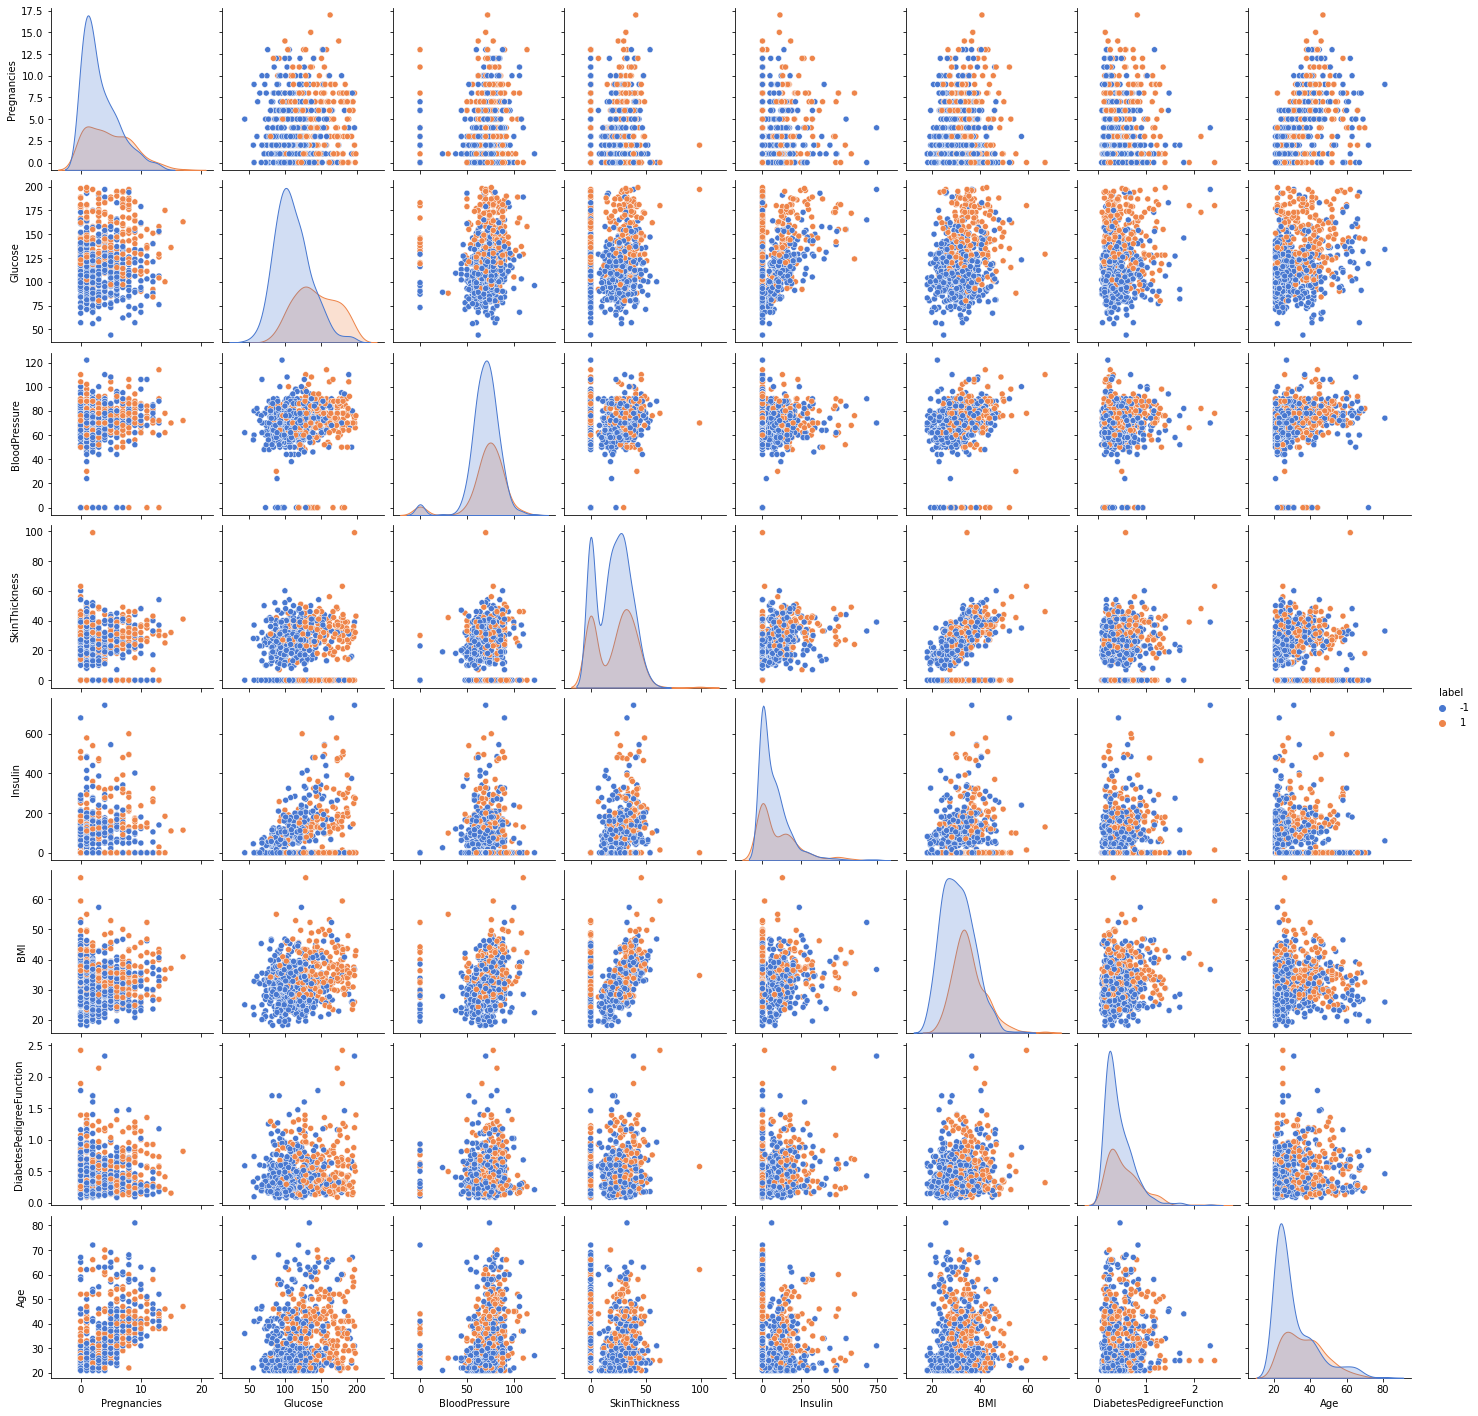

In [ ]:
df_x1=pd.DataFrame(x1,columns=attributes)
df_x1["label"]=y1
sns.pairplot(df_x1,hue="label",palette="muted")

By taking a look at the above PairGrid we can notice that some variables seem to help predict the class of data. For example, in the scatterplots where it is included, the variable **"Glucose"** seperates the data points into two different clusters of points. Patients with diabetes tend to have high glucose concentration, wheras others with low conentrations of glucose don't have diabetes. Also, the two distributions of Glucose concentrations plotted according to their classes have seperate supports. From a medical perspective this variable makes sense as we know that diabetes is highly correlated to the glucose concentration.

We also notice that **BMI** is correlated to the variable **Glucose**. This variable may also help with prediction.

If we take a look at the scatterplots including the variable **Age**, we notice that diabetes subjects tend to have high age values.

In [ ]:
n=300
x1_train,x1_test=x1[:n,:],x1[n:,:]
y1_train,y1_test=y1[:n],y1[n:]

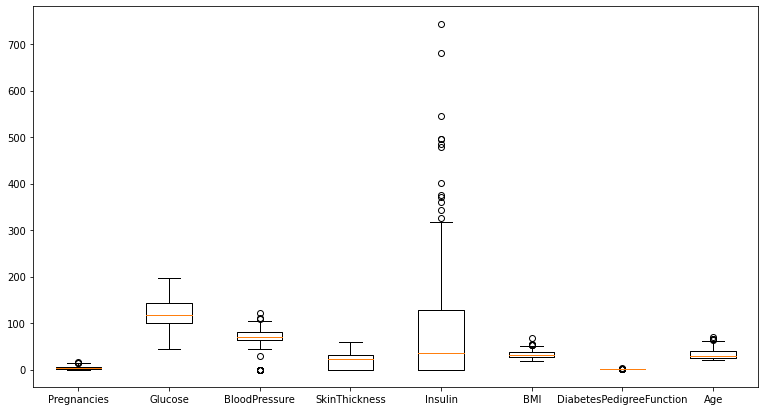

Pregnancies std: 3.32
Glucose std: 30.02
BloodPressure std: 17.89
SkinThickness std: 15.65
Insulin std: 116.10
BMI std: 7.29
DiabetesPedigreeFunction std: 0.33
Age std: 10.85


In [ ]:
pl.figure(figsize=(13,7))
plt.boxplot(x1_train,labels=attributes)
pl.show()
std_pima=x1_train.std(axis=0)
for i in range(len(attributes)):
  print(attributes[i]+" std: " +"{:.2f}".format(std_pima[i]))

Features have large different values of variances as we can see in the boxplot. We should scale the features values so that:
1.   We eliminate their dependencies towards units.
2.   variables are treated equally by the algorithms we are going to deploy.
3.   ensure rapid convergence of some algorithms.



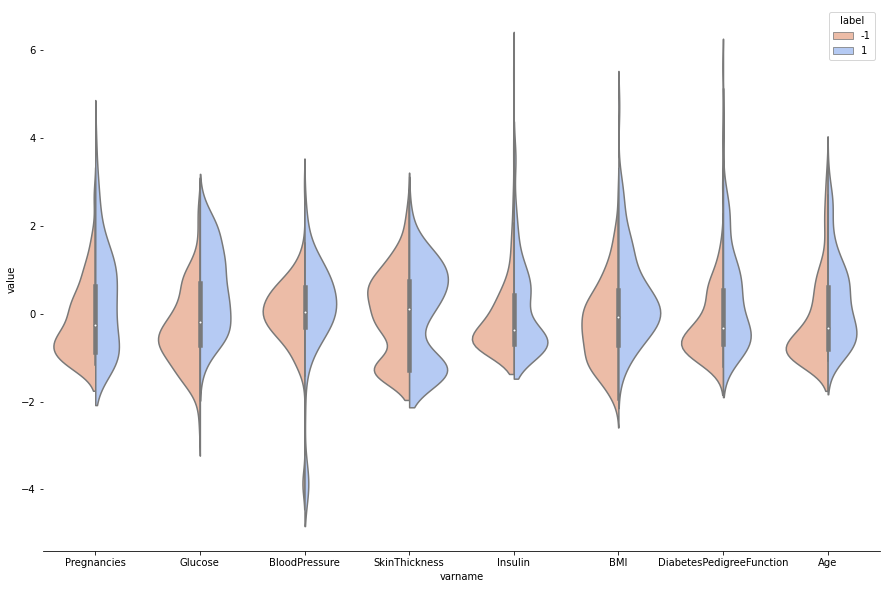

Pregnancies std: 1.00
Glucose std: 1.00
BloodPressure std: 1.00
SkinThickness std: 1.00
Insulin std: 1.00
BMI std: 1.00
DiabetesPedigreeFunction std: 1.00
Age std: 1.00


In [ ]:
scaler = StandardScaler()
x1_train=scaler.fit_transform(x1_train)
x1_test=scaler.fit_transform(x1_test)

df=pd.DataFrame(columns=["varname","value","label"])
for i in range(len(attributes)):
  var=attributes[i]
  for j in range(x1_train.shape[0]):
    df=df.append({"varname":var,"value":x1_train[j,i],"label":y1[j]},ignore_index=True)
pl.figure(figsize=(15,10))
sns.violinplot(x="varname",y="value",hue="label",data=df,palette="coolwarm_r",split=True)
sns.despine(left=True)
pl.show()

std_pima=x1_train.std(axis=0)
for i in range(len(attributes)):
  print(attributes[i]+" std: " +"{:.2f}".format(std_pima[i]))

We now see how features are scaled. And in the above violinplot we see also how the **Glucose** variable differentiates significantly well the two classes compared to most of the other features.

##2.2 Bayesian decision and linear classification

In [ ]:
lda_def=LDA()
lda_def.fit(x1_train,y1_train)
pred_class1=lda_def.predict_proba(x1_test)[:,1]
pred=lda_def.predict(x1_test)
print(f"accuracy score: {accuracy_score(y1_test,pred)}")
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.8117359413202934
AUC: 0.8619680560113773


In [ ]:
model=LDA()
ngrid=50
param_grid={"shrinkage":np.linspace(0,1,ngrid),"solver":['lsqr','eigen']}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
lda_opt = cv.best_estimator_
params_opt = cv.best_params_
pred=lda_opt.predict(x1_test)
print(f"optimal value of shrinkage: {params_opt['shrinkage']}")
print(f"solver: {params_opt['solver']}")
print(f"accuracy score: {accuracy_score(y1_test,pred)}")
pred_class1=lda_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of shrinkage: 0.02040816326530612
solver: lsqr
accuracy score: 0.8166259168704156
AUC: 0.8624056448966196


We note that the cross validation for the parameter "shrinkage" has lead to a better performance. The accuracy and AUC values increased compared to those of the default LDA model. 

In [ ]:
qda_def=QDA()
qda_def.fit(x1_train,y1_train)
pred_class1=qda_def.predict_proba(x1_test)[:,1]
print(f"accuracy score: {accuracy_score(y1_test,qda_def.predict(x1_test))}")
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.7481662591687042
AUC: 0.8092385953396783


The default QDA model shows less performance than the default LDA model.

In [ ]:
model=QDA()
ngrid=50
param_grid={"reg_param":np.linspace(0,1,ngrid)}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
qda_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of reg_param: {params_opt['reg_param']}")
print(f"accuracy score: {accuracy_score(y1_test,qda_opt.predict(x1_test))}")
pred_class1=qda_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of reg_param: 0.6122448979591836
accuracy score: 0.8019559902200489
AUC: 0.8558691609233126


The validation for the parameter "reg_param" increased notably the accuracy and AUC values compared to the default model.

In [ ]:
GNB_def = GaussianNB()
GNB_def.fit(x1_train,y1_train)
pred_class1=GNB_def.predict_proba(x1_test)[:,1]
print(f"accuracy score: {accuracy_score(y1_test,GNB_def.predict(x1_test))}")
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.7652811735941321
AUC: 0.8309265944645006


The two models LDA and QDA show better results of accuracy and AUC on test dataset than the Gaussian Naive Bayes model.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(x1_train,y1_train)
pred_class1=log_reg.predict_proba(x1_test)[:,1]
print(f"accuracy score: {accuracy_score(y1_test,log_reg.predict(x1_test))}")
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.80440097799511
AUC: 0.862296247675309


By comparing the metrics values of the logistic regressor to the other models, we notice that the logistic regressor has better performance than the Gaussian Naive Bayes model and the QDA model. However, the accuracy of the logistic regressor is slightly lower than the accuracy of the LDA and his AUC is slightly higher than the AUC of the LDA. Their performances are quite the same. The logistic regressor is a bit better as we can find another threshold of the logistic regressor classifier other than $0.5$ (the default value of the scikit learn package) insuring better accuracy. 

In [ ]:
model=LogisticRegression(penalty='l1',max_iter=200,random_state=seed)
ngrid=150
param_grid={"C":np.linspace(0,3,ngrid),'solver':['liblinear','saga']}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
log_reg_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of C: {params_opt['C']}")
print(f"accuracy score: {accuracy_score(y1_test,log_reg_opt.predict(x1_test))}")
pred_class1=log_reg_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of C: 0.28187919463087246
accuracy score: 0.8019559902200489
AUC: 0.8657422601465923


By doing a cross validation for the regularizer hyperparameter, we noticed that the accuracy value has slightly decreased and the AUC increased a little bit. The model is performing well compared to the rest of models.

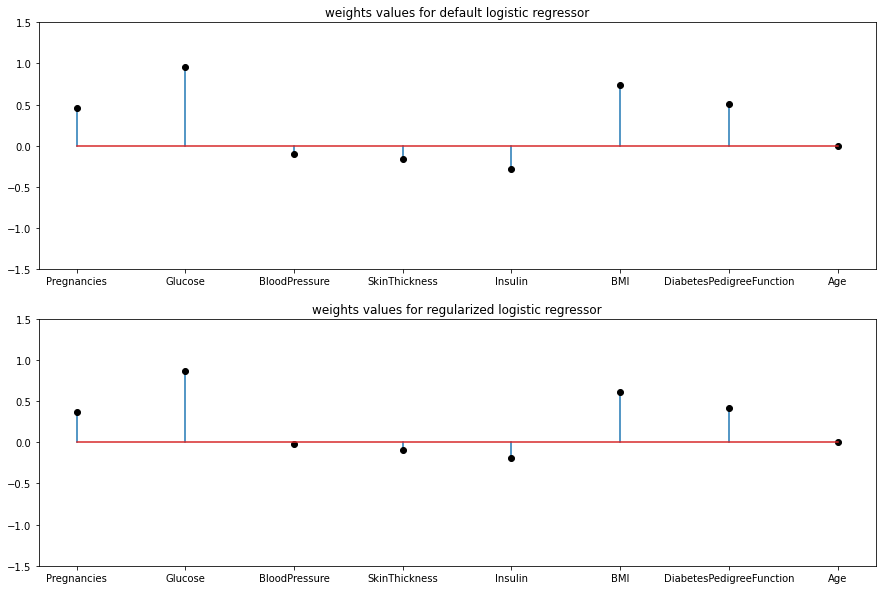

In [ ]:
fig,axes=pl.subplots(2,1,figsize=(15,10))
w=log_reg.coef_.flatten()
x=[i for i in range(1,x1_train.shape[1]+1)]

axes[0].stem(x, w ,markerfmt='ko')
axes[0].set_xticks(x, minor=False)
axes[0].set_xticklabels(attributes)
axes[0].axis(ymin=-1.5,ymax=1.5)
axes[0].set_title("weights values for default logistic regressor")


w=log_reg_opt.coef_.flatten()

axes[1].stem(x, w,markerfmt='ko')
axes[1].set_xticks(x, minor=False)
axes[1].set_xticklabels(attributes)
axes[1].axis(ymin=-1.5,ymax=1.5)
axes[1].set_title("weights values for regularized logistic regressor")

pl.show()

We see that as we noticed at the beginning, the most important feature is **Glucose concentration**. The other most important ones are **BMI**, **DiabetesPedigreeFunction** and **Pregnancies**. The weights of these variables were reduced a little bit by the l1 regularizer. They are positively correlated to the diabetes cases. In fact, diabetic patients tend to have high values of Glucose, BMI, DiabetesPedigreeFunction (they are more likely to catch diabetes if it's an hereditary disease) and number of pregnancies. Other variables like **Age**, **BloodPressure** and **SkinThickness** were removed by the model. Their weights are set to $0$. They don't interfere a lot in the prediction. The weight of the variable **insulin** was reduced. This variable has a negative weight meaning that samples affected with diabetes have low rates of insulin wich is logical since diabetic subjects don't produce enough insuline to reduce the glucose concentration.

The best results so far were obtained for linear models (LDA,LR) rather than quadratic models (QDA,GNB).

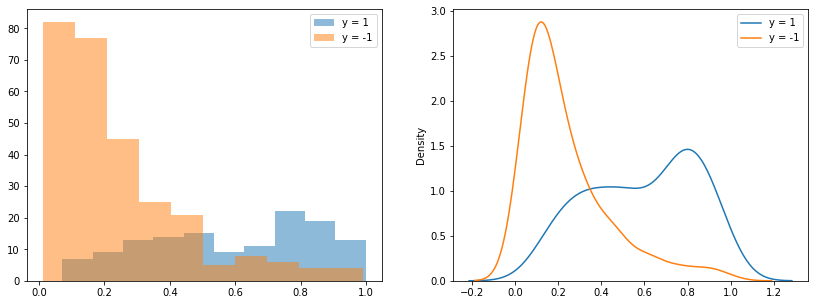

In [ ]:
fig,axes=pl.subplots(1,2,figsize=(14,5))

pred_class1=lda_opt.predict_proba(x1_test)[:,1]
axes[0].hist(pred_class1[y1_test==1],alpha=0.5,label="y = 1")
axes[0].hist(pred_class1[y1_test==-1],alpha=0.5,label="y = -1")
axes[0].legend()

sns.kdeplot(pred_class1[y1_test==1],ax=axes[1],label="y = 1")
sns.kdeplot(pred_class1[y1_test==-1],ax=axes[1],label="y = -1")
axes[1].legend()

pl.show()

For the LDA model that gave the best performance so far, we plotted the densities of the predicted scores in each class. Samples of the two classes seem to be well seperated. From the densities plot, we see that the peak of densities are on both sides of the threshhold $0.5$. We notice also that the variance of the non diabetic samples scores is lower than the variance of the diabetic samples. This means that the model predicts more accurately non diabetic samples than diabetic ones.

##2.3 Nonlinear methods

### Random forest

In [ ]:
rf=RFC(random_state=seed)
rf.fit(x1_train,y1_train)
y_pred=rf.predict(x1_test)

print(f"accuracy score: {accuracy_score(y1_test,y_pred)}")
pred_class1=rf.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.7775061124694377
AUC: 0.8557871130073297


The random forest classifier with default parameters doesn't show better performance than any of the linear models (logistic regressor and LDA).

In [ ]:
ngrid=100
model=RFC(random_state=seed)
param_grid={"max_features":np.linspace(0.1,0.9,num=ngrid)}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
rf_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of max_features: {params_opt['max_features']}")
print(f"accuracy score: {accuracy_score(y1_test,rf_opt.predict(x1_test))}")
pred_class1=rf_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of max_features: 0.38282828282828285
accuracy score: 0.7921760391198044
AUC: 0.8507001422163878


By tuning the "max_features" hyperparameter we could increase the accuracy of the random forest classifier. However the AUC was slightly reduced. In spite of this increase in accuracy the obtained model cannot conquer the linear models.

## SVC

In [ ]:
svc=SVC(probability=True,random_state=seed)
svc.fit(x1_train,y1_train)
y_pred=svc.predict(x1_test)

print(f"accuracy score: {accuracy_score(y1_test,y_pred)}")
pred_class1=svc.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.7921760391198044
AUC: 0.8406082485504868


The default SVC model performance is lower than linear models performance. We note that the accuracy of the SVC is close to the logistic regression accuracy by less than $0.01$. 

In [ ]:
ngrid=100
model=SVC(probability=True,random_state=seed)
param_grid={"C":np.linspace(0.1,10,ngrid)}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
svc_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of C: {params_opt['C']}")
print(f"accuracy score: {accuracy_score(y1_test,svc_opt.predict(x1_test))}")
pred_class1=svc_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of C: 0.30000000000000004
accuracy score: 0.7995110024449877
AUC: 0.8383382562082924


After the cross validation on the parameter "C" of the SVC model we noted a slight increase in the accuracy value. However the AUC value has decreased by a value of $0.02$. 

### MLP

In [ ]:
mlp=MLPClassifier(random_state=seed)
mlp.fit(x1_train,y1_train)
y_pred=mlp.predict(x1_test)

print(f"accuracy score: {accuracy_score(y1_test,y_pred)}")
pred_class1=mlp.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.784841075794621
AUC: 0.854146154687671


As the other non linear default models, the default MLP Classifier performance is not as good as the linear models.

In [ ]:
ngrid=100
model=MLPClassifier(random_state=seed)
param_grid={"alpha":np.logspace(-1,1,ngrid)}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
mlp_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of alpha: {params_opt['alpha']}")
print(f"accuracy score: {accuracy_score(y1_test,mlp_opt.predict(x1_test))}")
pred_class1=mlp_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of alpha: 0.8902150854450388
accuracy score: 0.7872860635696821
AUC: 0.8614210699048244


By doing a cross validation on the regularizer parameter "alpha" we could slightly increase the accuracy by $0.003$ and the AUC by $0.01$. Nonetheless, these values do not overtake the linear models performances.

### GBC

In [ ]:
gbc=GBC(random_state=seed)
gbc.fit(x1_train,y1_train)
y_pred=gbc.predict(x1_test)

print(f"accuracy score: {accuracy_score(y1_test,y_pred)}")
pred_class1=gbc.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

accuracy score: 0.7506112469437652
AUC: 0.8266601028333882


The gradient boosting performance is way lower then the linear models.

In [ ]:
ngrid=50
model=GBC(random_state=seed)
param_grid={"max_features":np.linspace(0.1,0.9,num=ngrid),"subsample":[0.3,0.4,0.5,0.6,0.7]}
cv = GridSearchCV(model,param_grid)
cv.fit(x1_train,y1_train)
gbc_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of max_features: {params_opt['max_features']}")
print(f"optimal value of subsample: {params_opt['subsample']}")
print(f"accuracy score: {accuracy_score(y1_test,gbc_opt.predict(x1_test))}")
pred_class1=gbc_opt.predict_proba(x1_test)[:,1]
print(f"AUC: {roc_auc_score(y1_test,pred_class1)}")

optimal value of max_features: 0.6387755102040816
optimal value of subsample: 0.5
accuracy score: 0.7799511002444988
AUC: 0.8415381249316268


We performed a cross validation on the parameters "max_features" and "subsample" of the GBC model. The accuracy increased nearly by $0.03$ and the AUC value increased by $0.02$. And the obtained model performance is still lower than the linear models.

##2.4 Comparison and interpretation

In [ ]:
models=[lda_opt,log_reg_opt,qda_opt,GNB_def,rf_opt,svc_opt,mlp_opt,gbc_opt]

data=pd.DataFrame(columns=["model","accuracy","AUC"])
data["model"]=["LDA","Logistic regression","QDA","GNB","random forest","SVC","MLP","Gradient boosting"]
data["accuracy"]=[accuracy_score(y1_test,model.predict(x1_test)) for model in models]
data["AUC"]=[roc_auc_score(y1_test,model.predict_proba(x1_test)[:,1]) for model in models]
data


,model,accuracy,AUC
0,LDA,0.816626,0.862406
1,Logistic regression,0.801956,0.865742
2,QDA,0.801956,0.855869
3,GNB,0.765281,0.830927
4,random forest,0.792176,0.850700
5,SVC,0.799511,0.838338
6,MLP,0.787286,0.861421
7,Gradient boosting,0.779951,0.841538


We see that the two first models in the above table have the best performance (regarding accuracy and AUC). These are the linear models (LDA and logistic regression).

From a medical and practical perspective, the best model is the one with good performance, interpretability and likely sparse. Between the tested models, the logistic regression model is the best one. He showed good performance among the tested model. The regularization of the model made it quite sparce with less variables. And also the logistic regression model is interpretable for medical results explanation. The non linearity is not necessary here as we achieved better results with linear models.

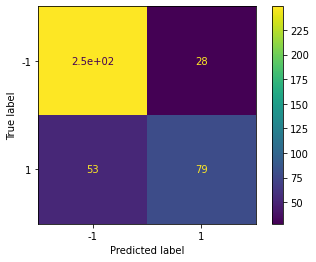

In [ ]:
cm=confusion_matrix(y1_test,log_reg_opt.predict(x1_test),labels=log_reg_opt.classes_)
ConfusionMatrixDisplay(cm,display_labels=log_reg_opt.classes_).plot()
pl.show()

In [ ]:
FNR=cm[1,0]/(cm[1,0]+cm[1,1])
print(f"FNR= {FNR}")

FNR= 0.4015151515151515


In the medical case it's better to have a low FNR rate. In fact, having high FNR rate means that many diabetic cases were classified as non diabetics which is a very dangerous case we should avoid.

In [ ]:
intercepts=np.linspace(-10,10,200)
acc=[]
FNR=[]
for i in range(len(intercepts)):
  log_reg_opt.intercept_=intercepts[i]
  preds=log_reg_opt.predict(x1_test)
  cm=confusion_matrix(y1_test,preds,labels=log_reg_opt.classes_)
  FNR.append(cm[1,0]/(cm[1,0]+cm[1,1]))
  acc.append(accuracy_score(y1_test,preds))

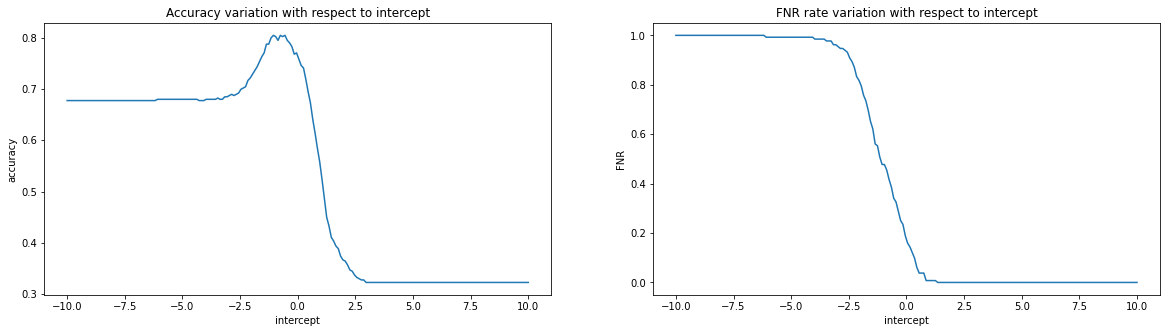

In [ ]:
fig,axes=pl.subplots(1,2,figsize=(20,5))
axes[0].plot(intercepts,acc)
axes[0].set_title("Accuracy variation with respect to intercept")
axes[0].set_xlabel("intercept")
axes[0].set_ylabel("accuracy")

axes[1].plot(intercepts,FNR)
axes[1].set_title("FNR rate variation with respect to intercept")
axes[1].set_xlabel("intercept")
axes[1].set_ylabel("FNR")
pl.show()

In [ ]:
intercept0=next(x for x in FNR if x < 0.1)                                      # The first intercept value ensuring FNR < 0.1
log_reg_opt.intercept_=intercept0

index0=np.where(FNR==intercept0)[0][0]
fnr0=FNR[index0]
acc0=acc[index0]
print(f"The value of the chosen intercept: {intercept0}")
print(f"FNR value: {fnr0}")
print(f"accuracy value: {acc0}")

The value of the chosen intercept: 0.09848484848484848
FNR value: 0.09848484848484848
accuracy value: 0.7188264058679706


#3 Predicting Classes on the Digits dataset

##3.1 Evaluate the different supervised methods

In [ ]:
models=[]
accuracies=[]
balanced_accuracies=[]
F1_scores=[]

###LDA

In [ ]:
lda_def=LDA()
lda_def.fit(x2,y2)
print(f"accuracy score: {accuracy_score(yt2,lda_def.predict(xt2))}")

accuracy score: 0.9333333333333333


In [ ]:
model=LDA()
ngrid=20
param_grid={"shrinkage":np.linspace(0,1,ngrid),"solver":['lsqr','eigen']}
cv = GridSearchCV(model,param_grid)
cv.fit(x2,y2)
lda_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of shrinkage: {params_opt['shrinkage']}")
print(f"solver: {params_opt['solver']}")
pred=lda_opt.predict(xt2)
acc=accuracy_score(yt2,pred)
f1=f1_score(yt2,pred,labels=lda_opt.classes_,average="macro")
bal_acc=balanced_accuracy_score(yt2,pred)
print(f"accuracy score: {acc}")

optimal value of shrinkage: 0.7894736842105263
solver: lsqr
accuracy score: 0.9406666666666667


In [ ]:
models.append("LDA")
accuracies.append(acc)
F1_scores.append(f1)
balanced_accuracies.append(bal_acc)

### Logistic regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(x2,y2)
print(f"accuracy score: {accuracy_score(yt2,log_reg.predict(xt2))}")

accuracy score: 0.9653333333333334


In [ ]:
model=LogisticRegression(penalty='l1',random_state=seed,solver='saga')
ngrid=10
param_grid={"C":np.linspace(0.1,5,ngrid)}
cv = GridSearchCV(model,param_grid)
cv.fit(x2,y2)
log_reg_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of C: {params_opt['C']}")
pred=log_reg_opt.predict(xt2)
acc=accuracy_score(yt2,pred)
f1=f1_score(yt2,pred,labels=log_reg_opt.classes_,average="macro")
bal_acc=balanced_accuracy_score(yt2,pred)
print(f"accuracy score: {acc}")

optimal value of C: 1.7333333333333336
accuracy score: 0.9673333333333334


In [ ]:
models.append("Logistic regression")
accuracies.append(acc)
F1_scores.append(f1)
balanced_accuracies.append(bal_acc)

### SVC

In [ ]:
svc=SVC(random_state=seed)
svc.fit(x2,y2)
y_pred=svc.predict(xt2)
print(f"accuracy score: {accuracy_score(yt2,y_pred)}")

accuracy score: 0.9833333333333333


In [ ]:
ngrid=20
model=SVC(random_state=seed)
param_grid={"C":np.linspace(0.1,10,ngrid)}
cv = GridSearchCV(model,param_grid)
cv.fit(x2,y2)
svc_opt = cv.best_estimator_
params_opt = cv.best_params_
print(f"optimal value of C: {params_opt['C']}")
pred=svc_opt.predict(xt2)
acc=accuracy_score(yt2,pred)
f1=f1_score(yt2,pred,labels=svc_opt.classes_,average="macro")
bal_acc=balanced_accuracy_score(yt2,pred)
print(f"accuracy score: {acc}")

optimal value of C: 4.268421052631579
accuracy score: 0.9846666666666667


In [ ]:
models.append("SVC")
accuracies.append(acc)
F1_scores.append(f1)
balanced_accuracies.append(bal_acc)

### MLP

In [ ]:
mlp=MLPClassifier(random_state=seed)
mlp.fit(x2,y2)
y_pred=mlp.predict(xt2)
print(f"accuracy score: {accuracy_score(yt2,y_pred)}")

accuracy score: 0.982


In [ ]:
mlp_opt=MLPClassifier(random_state=seed,hidden_layer_sizes=(100,20),alpha=0.005)
mlp_opt.fit(x2,y2)
preds=mlp_opt.predict(xt2)
acc=accuracy_score(yt2,pred)
f1=f1_score(yt2,pred,labels=mlp_opt.classes_,average="macro")
bal_acc=balanced_accuracy_score(yt2,pred)
print(f"accuracy score: {acc}")

accuracy score: 0.9846666666666667


In [ ]:
models.append("MLP")
accuracies.append(acc)
F1_scores.append(f1)
balanced_accuracies.append(bal_acc)

##3.2 Interpreting the classifier

In [ ]:
data=pd.DataFrame(columns=["model","accuracy","balanced accuracy","F1 score"])
data["model"]=models
data["accuracy"]=accuracies
data["balanced accuracy"]=balanced_accuracies
data["F1 score"]=F1_scores
data

,model,accuracy,balanced accuracy,F1 score
0,LDA,0.940667,0.940667,0.940758
1,Logistic regression,0.967333,0.967333,0.967353
2,SVC,0.984667,0.984667,0.984660
3,MLP,0.984667,0.984667,0.984660


We remark that the balanced accuracy values are equal to the accuracy. This is because the datased is balanced in train and test. 

The best model so far is the MLP.

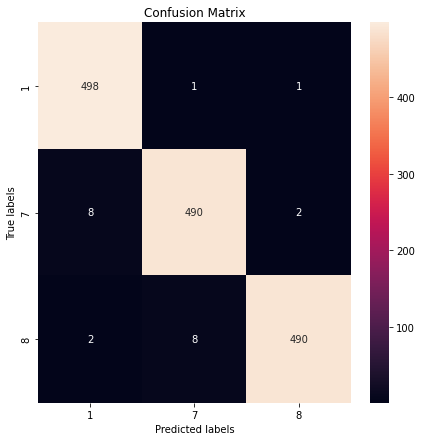

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
preds=mlp_opt.predict(xt2)
cm=confusion_matrix(yt2,preds,labels=mlp_opt.classes_)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '7','8']); ax.yaxis.set_ticklabels(['1', '7','8']);

In [ ]:
print(classification_report(yt2,preds,digits=4))

              precision    recall  f1-score   support

           1     0.9803    0.9960    0.9881       500
           7     0.9820    0.9800    0.9810       500
           8     0.9939    0.9800    0.9869       500

    accuracy                         0.9853      1500
   macro avg     0.9854    0.9853    0.9853      1500
weighted avg     0.9854    0.9853    0.9853      1500



We analyse the recall value and the confusion matrix to know the quality of prediction within a given class to determine the classes that are difficult to recognize. 

The class "1" has the highest precision value. In the confusion matrix, only 1 sample was classified as "7" and one sample as "8".

Both classes "7" and "8" have the same precision values. For the class "7" there are 8 samples that were classified as "1" and 2 samples as "8". We recall here the similarity of classes "7" and "1" having some inclined shapes. For the class "8", we have 8 samples that were classified as "7" and 2 samples as "1".

By this, we can say that classes "7" and "8" are the hardest one to recognize.

For the classes that are hard to discriminate, we the classes "7" and "8" as there are 8 saùmples of the class "8" that were misclassified as "7" and we have the classes "1" and "7" as there are 8 samples from class "7" that were misclassified as "1".

In [ ]:
index_1=[(i,preds[i]) for i in range(len(yt2)) if yt2[i] != preds[i] and yt2[i]==1]
index_7=[(i,preds[i]) for i in range(len(yt2)) if yt2[i] != preds[i] and yt2[i]==7]
index_8=[(i,preds[i]) for i in range(len(yt2)) if yt2[i] != preds[i] and yt2[i]==8]

Here we show images from class "1" that were misclassified.

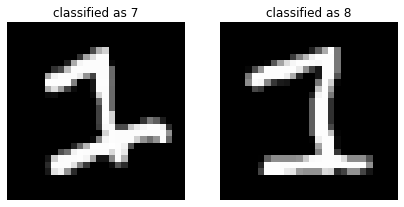

In [ ]:
plt.figure(figsize=(7, 7))
for i,e in enumerate(index_1):
  ind,label=e
  plt.subplot(1, 2, i+1)
  plt.imshow(xt2[ind].reshape((28,28)),cmap="gray")
  pl.title(f"classified as {label}")
  pl.axis('off')

The sample that was classified as "7" looks quite like the digit "7" with the inclined lines. The other one that was classified as "8" has a curve that could has tricked the classifier to be classified as "8".

Here we show images from class "7" that were misclassified.

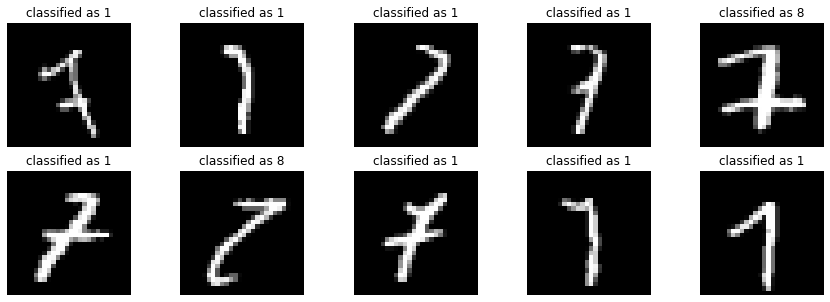

In [ ]:
plt.figure(figsize=(15, 5))
for i,e in enumerate(index_7):
  ind,label=e
  plt.subplot(2, 5, i+1)
  plt.imshow(xt2[ind].reshape((28,28)),cmap="gray")
  pl.title(f"classified as {label}")
  pl.axis('off')

We see that digits that were classified as "1" have a vertical thin shape as in the images of class "1". For example even for a human we can't tell that the last sample belongs to the class "7". For other images like the ones that were classified as "8" we see the presence of curves notably for the image in position (2,2) that has been classified as "8".

Here we show images from class "8" that were misclassified.

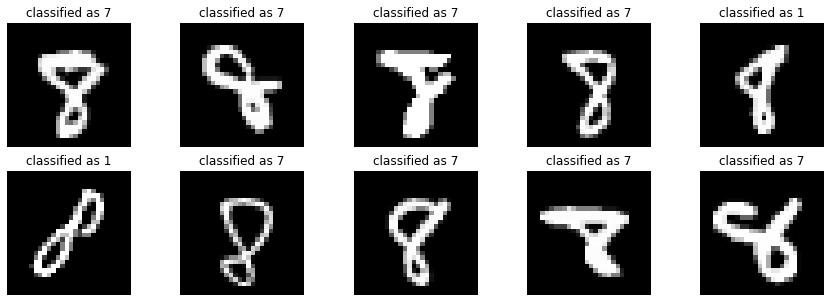

In [ ]:
plt.figure(figsize=(15, 5))
for i,e in enumerate(index_8):
  ind,label=e
  plt.subplot(2, 5, i+1)
  plt.imshow(xt2[ind].reshape((28,28)),cmap="gray")
  pl.title(f"classified as {label}")
  pl.axis('off')

Images that were classified as "7" have straight horizontal and vertical lines like the images in positions (1,3) and (2,4). The images that were classified as "1" have rather a thin and quite vertical shape like the image in position (1,5).

Is the sample of index 1015 well classified? [ True]


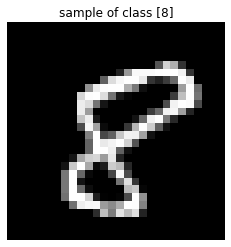

In [ ]:
ind=1015
im=xt2[ind]
print("Is the sample of index {} well classified? {}".format(ind,yt2[ind]==preds[ind]))
pl.imshow(im.reshape((28,28)),cmap="gray")
pl.title(f"sample of class {yt2[ind]}")
pl.axis('off')
pl.show()

In [ ]:
true_labels=yt2[ind]*np.ones((1000,1))
sig=np.linspace(0.1,5,40)
std_to_acc={}
std_to_samples={}
std_to_preds={}
for s in sig:
  adv=im
  for i in range(1000):
    X=s*randn(28*28)
    im_new=im+X
    adv=np.vstack( (adv, im_new) )
  adv=adv[1:,:]
  std_to_samples[s]=adv
  adv_pred=mlp_opt.predict(adv)
  std_to_preds[s]=adv_pred
  acc_adv=accuracy_score(true_labels,adv_pred)
  std_to_acc[s]=acc_adv

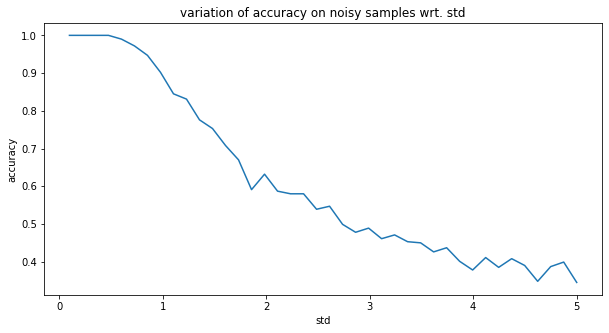

In [ ]:
plt.figure(figsize=(10, 5))
pl.plot(sig,list(std_to_acc.values()))
pl.title("variation of accuracy on noisy samples wrt. std")
pl.xlabel("std")
pl.ylabel("accuracy")
pl.show()

We see how by increasing the standard deviation we could trick the model. The accuracy keeps falling down as long as we increase the value of the std.

We can say that the classifier is quite robust. The accuracy kept a high value close to 1 as long as we increased the std value to 1. To visualise some of the adversarial samples, we choose a value of std giving an accuracy lower than 1.

In [ ]:
std=0.6025641025641025
std_to_acc[std]

0.99

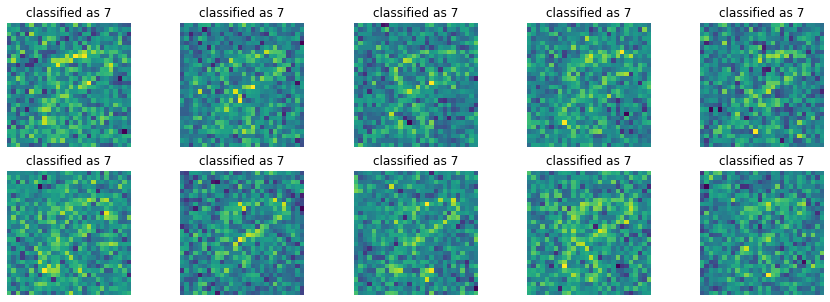

In [ ]:
X=std_to_samples[std]
pred_X=std_to_preds[std]
index_adv=[i for i in range(1000) if pred_X[i]!=yt2[ind]]

plt.figure(figsize=(15, 5))
for i,indx in enumerate(index_adv[:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(X[indx].reshape((28,28)))
  pl.title(f"classified as {pred_X[indx]}")
  pl.axis('off')

We see how by adding a small amount of noise we could trick the classifier. The 8 shape can be seen in these figures by its 

# Bonus: CNN

In [ ]:
X2=x2.reshape(x2.shape[0],28,28,1)         
Xt2=xt2.reshape(xt2.shape[0],28,28,1)        

In [ ]:
Y2 = to_categorical(y2[:,0])
Yt2 = to_categorical(yt2[:,0])

In [ ]:
learning_rate = 0.01
n_epochs = 8
batch_size = 32

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = nb_channels  # number of input channels
n_h_1 = nb_filters
n_h_2 = nb_filters

In [ ]:
model = Sequential([
  Conv2D(n_h_1,kernel_size=(3,3),strides=1,padding="same",input_shape=(28,28,n_h_0),activation="relu"),
  Conv2D(n_h_2,kernel_size=(3,3),strides=1,padding="same",activation="relu"),
  MaxPooling2D(pool_size=(2,2),strides=2),
  Flatten(),
  Dense(units=9,activation="softmax")
])

In [ ]:
model.summary()



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics="accuracy")

model.fit(X2,Y2,epochs=n_epochs,batch_size=batch_size)

score = model.evaluate(Xt2, Yt2, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 56457     
Total params: 66,025
Trainable params: 66,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
94/94 [==============================] - 6s 64ms/step - loss: 0.0348 - accuracy: 0.9913
Epoch 2/8
94/94 [=

We see that the CNN model has better performance on test data. The accuracy of the model on test dataset is higher by $0.002$.

In [ ]:
for s in sig:
  std_to_samples[s]=std_to_samples[s].reshape(1000,28,28,1)

In [ ]:
acc=[]
Y = to_categorical(true_labels[:,0])
for s in sig:
  score = model.evaluate(std_to_samples[s], Y, verbose=False)
  acc.append(score[1])

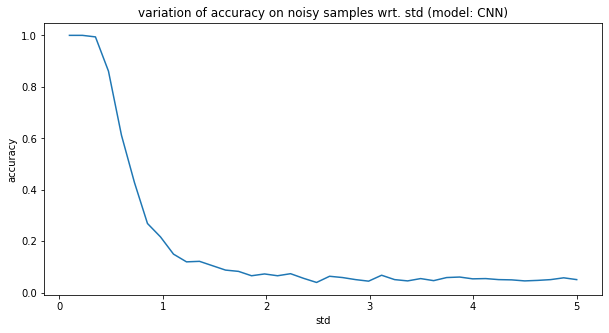

In [ ]:
plt.figure(figsize=(10, 5))
pl.plot(sig,acc)
pl.title("variation of accuracy on noisy samples wrt. std (model: CNN)")
pl.xlabel("std")
pl.ylabel("accuracy")
pl.show()

We see that the CNN model is less robust to adverarial samples than the MLP model. The accuracy decreases faster with the increased values of standard deviations.